# ImagenetOS

In [1]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
from train_model import train_model
from test_model import test_model
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='3'

## Load Dataset

In [3]:
def get_dataset(path='/database', dataset_name='imagenetOS/base/val'):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomCrop(224),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name, data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name, data_transforms['test'])
    print('{} train set size: {}'.format(dataset_name, len(tr_dataset)))
    print('{} test set size: {}'.format(dataset_name, len(te_dataset)))

    return tr_dataset, te_dataset

In [4]:
def split_dataset(train_dataset, test_dataset, valid_size=0.2, batch_size=128):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.seed(10)
    random.shuffle(indices)
    train_idx, valid_idx, test_idx = indices[split*2:], indices[:split], indices[split:split*2]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = train_sampler)
    val_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = valid_sampler)
    test_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = test_sampler)
    dataloaders = {'train': train_loader,
                   'val': val_loader,
                   'test': test_loader}
    dataset_sizes ={'train': int(np.floor((1-valid_size*2) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes

In [5]:
imagebase = '/local/rcs/ll3504/datasets/'

In [6]:
def load_all_dataset(split=0.2, batch_size=128):
    cities = ['base', 'New_York', 'California', 'Tibet', 'Beijing', 'New_South_Wales', 'United_Kingdom', 'Quebec']
    dataloaders = {}
    dataset_sizes = {}
    for city in cities:
        train_images, test_images = get_dataset(imagebase, 'imagenetOS/'+city+'/val/')
        dataloader, dataset_size = split_dataset(train_images, test_images, split, batch_size)
        dataloaders[city] = dataloader
        dataset_sizes[city] = dataset_size
    return dataloaders, dataset_sizes

In [7]:
dataloaders, dataset_sizes = load_all_dataset(0.2, 128)

imagenetOS/base/val/ train set size: 92600
imagenetOS/base/val/ test set size: 92600
imagenetOS/New_York/val/ train set size: 10201
imagenetOS/New_York/val/ test set size: 10201
imagenetOS/California/val/ train set size: 10201
imagenetOS/California/val/ test set size: 10201
imagenetOS/Tibet/val/ train set size: 10201
imagenetOS/Tibet/val/ test set size: 10201
imagenetOS/Beijing/val/ train set size: 10201
imagenetOS/Beijing/val/ test set size: 10201
imagenetOS/New_South_Wales/val/ train set size: 10201
imagenetOS/New_South_Wales/val/ test set size: 10201
imagenetOS/United_Kingdom/val/ train set size: 10201
imagenetOS/United_Kingdom/val/ test set size: 10201
imagenetOS/Quebec/val/ train set size: 10201
imagenetOS/Quebec/val/ test set size: 10201


## Finetuning models

In [8]:
#Load Resnet50
model = models.resnet50(True)
#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(2048, 201)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 1/10
----------
Iteration: 144/144, Loss: 182.29713439941406.Train Loss: 3.1850 Acc: 0.5391
Val Loss: 1.4693 Acc: 0.7754

Epoch 2/10
----------
Iteration: 144/144, Loss: 106.84004974365234.Train Loss: 1.0879 Acc: 0.8140
Val Loss: 0.7957 Acc: 0.8343

Epoch 3/10
----------
Iteration: 144/144, Loss: 78.32205963134766..Train Loss: 0.7023 Acc: 0.8536
Val Loss: 0.6125 Acc: 0.8532

Epoch 4/10
----------
Iteration: 144/144, Loss: 80.29058074951172..Train Loss: 0.5514 Acc: 0.8747
Val Loss: 0.5319 Acc: 0.8629

Epoch 5/10
----------
Iteration: 144/144, Loss: 82.88539123535156..Train Loss: 0.4683 Acc: 0.8874
Val Loss: 0.4855 Acc: 0.8670

Epoch 6/10
----------
Iteration: 144/144, Loss: 62.58845138549805..Train Loss: 0.4104 Acc: 0.8976
Val Loss: 0.4645 Acc: 0.8694

Epoch 7/10
----------
Iteration: 144/144, Loss: 41.00949478149414..Train Loss: 0.3646 Acc: 0.9068
Val Loss: 0.4446 Acc: 0.8733

Epoch 8/10
----------
Iteration: 144/144, Loss: 70.35311126708984..Train Loss: 0.3308 Acc: 0.9152
Val Lo

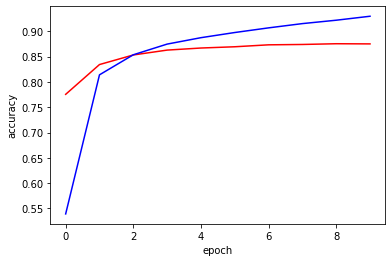

Training complete in 37m 48s
Best Validation Accuracy: 0.8754319654427646, Epoch: 9


In [9]:
#Train
train_model("imagenetOS_base", model, dataloaders['base'], dataset_sizes['base'], criterion, optimizer, num_epochs=10)

## Evaluate Models

In [11]:
#Test Resnet50-224
model_OS = models.resnet50()
#Finetune Final few layers to adjust for tiny imagenet input
model_OS.avgpool = nn.AdaptiveAvgPool2d(1)
model_OS.fc = nn.Linear(2048, 201)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_OS.load_state_dict(torch.load('models/imagenetOS_base/model_10_epoch.pt'))
model_OS = model_OS.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model_OS.parameters(), lr=0.001, momentum=0.9)

In [12]:
def evaluate_models(model, dataloaders, dataset_sizes, criterion, optimizer):
    cities = ['New_York', 'California', 'Tibet', 'Beijing', 'New_South_Wales', 'United_Kingdom', 'Quebec']
    for city in cities:
        print('Testing '+ city + '......')
        test_model(model, dataloaders[city], dataset_sizes[city], criterion, optimizer)
        print('Finish testing!\n')

In [13]:
evaluate_models(model_OS, dataloaders, dataset_sizes, criterion, optimizer)

Testing New_York......
Iteration: 15/15, Loss: 65.06603240966797..
Test Loss: 0.6756 Acc: 0.7534

Test complete in 0m 6s
Finish testing!

Testing California......
Iteration: 15/15, Loss: 109.66531372070312.
Test Loss: 0.6868 Acc: 0.7510

Test complete in 0m 6s
Finish testing!

Testing Tibet......
Iteration: 15/15, Loss: 89.19581604003906..
Test Loss: 0.5489 Acc: 0.7956

Test complete in 0m 7s
Finish testing!

Testing Beijing......
Iteration: 15/15, Loss: 94.46394348144531.
Test Loss: 0.6330 Acc: 0.7750

Test complete in 0m 6s
Finish testing!

Testing New_South_Wales......
Iteration: 15/15, Loss: 113.697265625.156..
Test Loss: 0.6645 Acc: 0.7603

Test complete in 0m 6s
Finish testing!

Testing United_Kingdom......
Iteration: 15/15, Loss: 66.34413146972656.
Test Loss: 0.6431 Acc: 0.7627

Test complete in 0m 6s
Finish testing!

Testing Quebec......
Iteration: 15/15, Loss: 68.1668930053711..
Test Loss: 0.6720 Acc: 0.7583

Test complete in 0m 6s
Finish testing!

